In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importo le librerie

In [ ]:
###########################
# IMPORT
import scipy.io as sio
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as dataloader
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import random
from random import shuffle
import matplotlib.pyplot as plt
######################################

# Rendo il tutto deterministico

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check Device


In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.10.0+cu111
True
Tesla K80
cuda:0


# Caricamento Dati

In [ ]:
#Dataset per i file numpy (da usarsi come argomento del dataloader)
class NumpyDataset(dataloader.Dataset):
  def __init__(self, root_path):
    self.data_numpy_list = next(os.walk(root_path))[2] 
    self.data_list = []
    self.class_list = []
    for ind in range(len(self.data_numpy_list)):
      data_slice_file_name = root_path + self.data_numpy_list[ind]
      data_i = np.load(data_slice_file_name, allow_pickle=True)
      self.data_list.append(data_i[0])
      self.class_list.append(data_i[1])

  def __getitem__(self, index):
    self.data = np.asarray(self.data_list[index])
    self.data = np.resize(self.data,(224,224))   #resize
    self.data = np.stack((self.data, self.data, self.data))   #1 to 3 channels
    self.data[0,:,:] = (self.data[0,:,:] - 0.485)/0.229       #norm channel 0
    self.data[1,:,:] = (self.data[1,:,:] - 0.456)/0.224       #norm channel 1
    self.data[2,:,:] = (self.data[2,:,:] - 0.406)/0.225       #norm channel 2
    return torch.from_numpy(self.data).float(), self.class_list[index]

  def __len__(self):
    return len(self.data_numpy_list)
    
image_datasets = {x: NumpyDataset("drive/MyDrive/Colab Notebooks/Contest_3/" + x +"/") for x in ['training_set', 'validation_set']}
len(image_datasets['training_set'])
len(image_datasets['validation_set'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4) for x in ['training_set', 'validation_set']}
#print(len(image_datasets['training_set']))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Definizione Funzione

In [ ]:
def train_loop_validation(dataloaders, startEpoch, numEpochs, model_conv, criterionCNN, optimizer_conv,best_acc,best_loss,best_epoca,outputPath):
    for epochs in range(startEpoch,numEpochs + 1):
      since = time.time()
      modelLoss_train = 0.0
      modelAcc_train = 0.0

      model_conv.train()
      totalSize = 0

      #per ogni batch
      for inputs, labels in dataloaders['training_set']:
          inputs = inputs.type(torch.FloatTensor).cuda()
          labels = labels.cuda()

          optimizer_conv.zero_grad()
          model_conv.zero_grad()

          y= model_conv(inputs)
          outp, preds = torch.max(y,1)

          lossCNN = criterionCNN(y, labels) #media per batch

          modelLoss_train += lossCNN.item()*inputs.size(0)
          totalSize += inputs.size(0)
          modelAcc_train += torch.sum(preds == labels.data).item()

          lossCNN.backward()
          optimizer_conv.step()

      modelLoss_epoch_train = modelLoss_train/totalSize
      modelAcc_epoch_train = modelAcc_train/totalSize
   
      #salvataggio stato
      torch.save(model_conv.state_dict(), outputPath + 'train_weights.pth') 
      model_conv.eval()
      totalSize_val = 0
      modelLoss_val = 0.0 
      modelAcc_val = 0.0

      for inputs,labels in dataloaders['validation_set']:
        inputs = inputs.type(torch.FloatTensor).cuda()
        labels = labels.cuda()

        y = model_conv(inputs)
        outp, preds = torch.max(y,1)
        lossCNN = criterionCNN(y,labels)

        modelLoss_val += lossCNN.item()*inputs.size(0)
        totalSize_val += inputs.size(0)
        modelAcc_val += torch.sum(preds == labels.data).item()

      modelLoss_epoch_val = modelLoss_val/totalSize_val
      modelAcc_epoch_val = modelAcc_val/totalSize_val
      time_elapsed = time.time()-since
      
      print('[Epoch %d][TRAIN on %d [Loss: %.4f Acc: %.4f]][VAL on %d [Loss: %.4f Acc: %.4f]][TIME: %.0f m %.0f s]' %(epochs, totalSize, modelLoss_epoch_train, modelAcc_epoch_train, totalSize_val, modelLoss_epoch_val, modelAcc_epoch_val, time_elapsed // 60, time_elapsed %60))

      if(modelAcc_epoch_val > best_acc) or (modelAcc_epoch_val == best_acc and modelLoss_epoch_val < best_loss):
        print('..... Saving best weights ....')
        best_acc = modelAcc_epoch_val
        best_loss = modelLoss_epoch_val
        best_epoca = epochs

        torch.save(model_conv.state_dict(), outputPath + 'best_model_weights.pth')

      with open(outputPath +'lossTrain.txt', "a") as file_object:
        file_object.write(str(modelLoss_epoch_train)+ '\n')

      with open(outputPath +'AccTrain.txt',"a") as file_object:
        file_object.write(str(modelAcc_epoch_train)+ '\n')

      with open(outputPath + 'lossVal.txt', "a") as file_object:
        file_object.write(str(modelLoss_epoch_val)+ '\n')

      with open(outputPath + 'AccVal.txt',"a") as file_object:
        file_object.write(str(modelAcc_epoch_val)+ '\n')

      sio.savemat(outputPath + 'check_point.mat',{'best_acc': best_acc,
                                                  'best_loss': best_loss,
                                                  'best_epoca': best_epoca,
                                                  'last_epoch' : epochs})
      


# Parametri

In [ ]:
networkName = 'Alexnet'
WeightPath = '/content/'+ networkName + '/'
model_conv = torchvision.models.alexnet(pretrained=True)
model_conv.classifier[6] = nn.Linear(4096,3)

#num epoche,learning rate, batch size
learning_rate = 0.0001
batch_size = 16
num_epoch = 100

for param in model_conv.parameters():
  param.requires_grad = False

for param in model_conv.classifier.parameters():
  param.requires_grad = True

model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr=learning_rate)

startEpoch = 1
best_acc = 0
best_loss = 0
best_epoca = 0

train_loop_validation(dataloaders, startEpoch, num_epoch, model_conv, criterion, optimizer_conv, best_acc, best_loss, best_epoca, WeightPath)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 1][TRAIN on 857 [Loss: 0.7826 Acc: 0.7410]][VAL on 170 [Loss: 0.7570 Acc: 0.7353]][TIME: 0 m 8 s]
..... Saving best weights ....
[Epoch 2][TRAIN on 857 [Loss: 0.4880 Acc: 0.8366]][VAL on 170 [Loss: 0.6424 Acc: 0.8235]][TIME: 0 m 9 s]
..... Saving best weights ....
[Epoch 3][TRAIN on 857 [Loss: 0.3747 Acc: 0.8646]][VAL on 170 [Loss: 0.5296 Acc: 0.8000]][TIME: 0 m 9 s]
[Epoch 4][TRAIN on 857 [Loss: 0.2869 Acc: 0.8938]][VAL on 170 [Loss: 0.7854 Acc: 0.8235]][TIME: 0 m 8 s]
[Epoch 5][TRAIN on 857 [Loss: 0.3189 Acc: 0.8926]][VAL on 170 [Loss: 0.4219 Acc: 0.8588]][TIME: 0 m 9 s]
..... Saving best weights ....
[Epoch 6][TRAIN on 857 [Loss: 0.2715 Acc: 0.9020]][VAL on 170 [Loss: 0.6573 Acc: 0.8529]][TIME: 0 m 9 s]
[Epoch 7][TRAIN on 857 [Loss: 0.2367 Acc: 0.9242]][VAL on 170 [Loss: 0.5200 Acc: 0.8529]][TIME: 0 m 8 s]
[Epoch 8][TRAIN on 857 [Loss: 0.2052 Acc: 0.9265]][VAL on 170 [Loss: 0.5203 Acc: 0.8647]][TIME: 0 m 8 s]
..... Saving best weights ....
[Epoch 9][TRAIN on 857 [Loss: 0.2531

KeyboardInterrupt: ignored

# Resnet


In [ ]:
#b_s 32, lr 0.0001, n_e = 100
#b_s 32, lr 0.001, n_e = 100

networkName = 'Resnet-18'
WeightPath = '/content/'+ networkName + '/'
model_conv = torchvision.models.resnet18(pretrained=True)
model_conv.fc = nn.Linear(512,3)

#num epoche,learning rate, batch size
learning_rate = 0.0001
batch_size = 16
num_epoch = 200

for param in model_conv.parameters():
  param.requires_grad = False

for param in model_conv.fc.parameters():
  param.requires_grad = True

model_conv = model_conv.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=learning_rate)

startEpoch = 1
best_acc = 0
best_loss = 0
best_epoca = 0

train_loop_validation(dataloaders, startEpoch, num_epoch, model_conv, criterion, optimizer_conv, best_acc, best_loss, best_epoca, WeightPath)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 1][TRAIN on 857 [Loss: 1.0885 Acc: 0.4434]][VAL on 170 [Loss: 1.0922 Acc: 0.3941]][TIME: 0 m 6 s]
..... Saving best weights ....
[Epoch 2][TRAIN on 857 [Loss: 0.9990 Acc: 0.5146]][VAL on 170 [Loss: 0.9753 Acc: 0.5235]][TIME: 0 m 6 s]
..... Saving best weights ....
[Epoch 3][TRAIN on 857 [Loss: 0.9075 Acc: 0.6033]][VAL on 170 [Loss: 0.9078 Acc: 0.5882]][TIME: 0 m 6 s]
..... Saving best weights ....
[Epoch 4][TRAIN on 857 [Loss: 0.8369 Acc: 0.6651]][VAL on 170 [Loss: 0.8455 Acc: 0.6294]][TIME: 0 m 6 s]
..... Saving best weights ....
[Epoch 5][TRAIN on 857 [Loss: 0.8071 Acc: 0.6744]][VAL on 170 [Loss: 0.7939 Acc: 0.6941]][TIME: 0 m 6 s]
..... Saving best weights ....
[Epoch 6][TRAIN on 857 [Loss: 0.7623 Acc: 0.7036]][VAL on 170 [Loss: 0.7587 Acc: 0.7059]][TIME: 0 m 6 s]
..... Saving best weights ....
[Epoch 7][TRAIN on 857 [Loss: 0.7371 Acc: 0.7048]][VAL on 170 [Loss: 0.7203 Acc: 0.7294]][TIME: 0 m 6 s]
..... Saving best weights ....
[Epoch 8][TRAIN on 857 [Loss: 0.6846 Acc: 0.7503

# Grafici

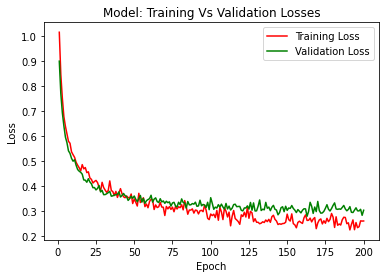

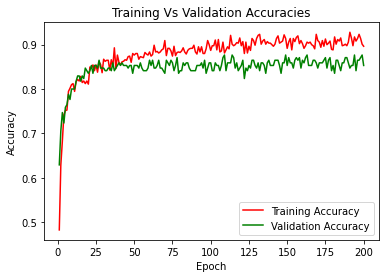

In [ ]:
#resnet18
#b_s 32, lr 0.001, epoch 150
#acc train 0.93, acc val 0.8824, acc kaggle 0.8823
lossModel_Train = []
lossModel_val = []
accModel_Train = []
accModel_val = []

WeightPath = 'Resnet-18/'
file = open(WeightPath + 'lossTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_Train.append(float(element))

file = open(WeightPath + 'lossVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  lossModel_val.append(float(element))

plt.figure()
plt.title("Model: Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(list(range(1,len(lossModel_Train)+1)), lossModel_Train, color='r', label="Training Loss")
plt.plot(list(range(1, len(lossModel_val)+1)), lossModel_val, color='g', label="Validation Loss")
plt.legend()
plt.savefig(WeightPath + 'LossTrainVal.png')

file = open(WeightPath + 'AccTrain.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_Train.append(float(element))

file = open(WeightPath + 'AccVal.txt', 'r')
Testo = file.readlines()
for element in Testo:
  accModel_val.append(float(element))

plt.figure()
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(accModel_Train)+1)), accModel_Train, color='r', label="Training Accuracy")
plt.plot(list(range(1, len(accModel_val)+1)), accModel_val, color='g', label="Validation Accuracy")
plt.legend()
plt.savefig(WeightPath + 'AccTrainVal.png')

In [ ]:
from PIL import Image


Test = pd.DataFrame()

classes = ['0','1','2']
#WeightPath = '/content/' + networkName

model_conv = torchvision.models.resnet18(pretrained=True)
model_conv.fc = nn.Linear(512, 3)
#model_conv = torchvision.models.googlenet(pretrained=True)
#model_conv.fc = nn.Linear(1024, set_classes_number)

model_conv.load_state_dict(torch.load('/content/Resnet-18' + '/best_model_weights.pth'))


#model_conv.load_state_dict(torch.load('/content/gdrive/My Drive/DataMining_EsercitazioneDeepLearning/AlexNet/' + '/best_weight.pth'))
model_conv = model_conv.cuda()
model_conv.eval()

data_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])


pathtest = '/content/drive/MyDrive/Colab Notebooks/Contest_3/test_set'
listImage = os.listdir(pathtest)
for input in listImage:
  print('Working on '+ input)
  img = np.load( pathtest + '/' +input)
  img = np.resize(img,(224,224))   #resize
  img = np.stack((img, img, img))   #1 to 3 channels
  img[0,:,:] = (img[0,:,:] - 0.485)/0.229       #norm channel 0
  img[1,:,:] = (img[1,:,:] - 0.456)/0.224       #norm channel 1
  img[2,:,:] = (img[2,:,:] - 0.406)/0.225       #norm channel 2
  img=torch.from_numpy(img).float().to(device)
  #img = data_transforms(img).to(device)
  img = img.unsqueeze_(0)
  outputs = model_conv(img)
  _, predicted = torch.max(outputs, 1)
  Test = Test.append({'ID': input.split('.')[0],
                      'Class': int(classes[predicted.item()])}, ignore_index = True)
  

Working on 8.npy
Working on 163.npy
Working on 22.npy
Working on 10.npy
Working on 151.npy
Working on 9.npy
Working on 32.npy
Working on 126.npy
Working on 168.npy
Working on 46.npy
Working on 90.npy
Working on 74.npy
Working on 83.npy
Working on 164.npy
Working on 89.npy
Working on 82.npy
Working on 99.npy
Working on 35.npy
Working on 20.npy
Working on 84.npy
Working on 139.npy
Working on 141.npy
Working on 136.npy
Working on 143.npy
Working on 125.npy
Working on 133.npy
Working on 162.npy
Working on 115.npy
Working on 11.npy
Working on 137.npy
Working on 81.npy
Working on 165.npy
Working on 42.npy
Working on 160.npy
Working on 145.npy
Working on 40.npy
Working on 107.npy
Working on 138.npy
Working on 106.npy
Working on 130.npy
Working on 38.npy
Working on 80.npy
Working on 152.npy
Working on 88.npy
Working on 128.npy
Working on 5.npy
Working on 26.npy
Working on 75.npy
Working on 56.npy
Working on 135.npy
Working on 23.npy
Working on 50.npy
Working on 30.npy
Working on 13.npy
Working

In [ ]:
print(Test['Class'])
Test[['ID','Class']].to_excel('Test_15_12_2.xlsx')

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
165    1.0
166    1.0
167    1.0
168    1.0
169    1.0
Name: Class, Length: 170, dtype: float64


we have an accuracy of 0.847 on private leaderboard
